# Data used in this notebook
- market_cap.csv
- portfolio_sale.csv

In [77]:
import pandas as pd

In [78]:
market_cap=pd.read_csv('market_cap.csv') # monthly mktcap for each gvkey, with year and month num
market_cap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21692 entries, 0 to 21691
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PERMNO    21692 non-null  int64  
 1   MthCalDt  21692 non-null  object 
 2   MthCap    21692 non-null  float64
 3   gvkey     21692 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 678.0+ KB


In [79]:
# creat year and month
market_cap['MthCalDt'] = pd.to_datetime(market_cap['MthCalDt'], format='%Y/%m/%d')
market_cap['year'] = market_cap['MthCalDt'].dt.year
market_cap['month'] = market_cap['MthCalDt'].dt.month
market_cap = market_cap.drop(columns=['MthCalDt'])
print(market_cap.describe())
market_cap.to_csv('market_cap2.csv')
market_cap.tail()

             PERMNO        MthCap          gvkey          year         month
count  21692.000000  2.169200e+04   21692.000000  21692.000000  21692.000000
mean   77955.165775  4.584563e+06  153503.101835   2011.761110      6.515029
std    27012.647796  9.662385e+06   32019.133455      6.162657      3.457175
min    12009.000000  3.681480e+03  105365.000000   1996.000000      1.000000
25%    86316.000000  4.906814e+05  127575.000000   2007.000000      4.000000
50%    88917.000000  1.467253e+06  155394.000000   2012.000000      7.000000
75%    90870.000000  4.103633e+06  175404.000000   2017.000000     10.000000
max    93387.000000  1.332086e+08  315318.000000   2023.000000     12.000000


,PERMNO,MthCap,gvkey,year,month
21687,14406,3991535.37,315318,2022,9
21688,14406,4163879.20,315318,2022,10
21689,14406,4735202.16,315318,2022,11
21690,14406,4403544.34,315318,2022,12
21691,14406,4957921.28,315318,2023,1


In [80]:
import pandas as pd

# Assuming market_cap DataFrame is already defined and has columns: gvkey, year, month, MthCap

# Initialize empty DataFrame to store annual returns
merged_yret = pd.DataFrame()

# Group by gvkey
for gvkey in market_cap['gvkey'].unique():
    key_data = market_cap[market_cap['gvkey'] == gvkey]

    # Group by year within each gvkey
    for year in key_data['year'].unique():
        # Create a copy of the data for a specific year
        year_data = key_data[key_data['year'] == year].copy()

        # Calculate monthly returns
        year_data['mret'] = year_data['MthCap'].pct_change()*100

        # Calculate the cap-weighted annual return
        capsum = year_data['MthCap'][1:].sum()
        year_data['weighted_ret'] = 12 * year_data['mret'] * year_data['MthCap'] / capsum
        annual_return = year_data['weighted_ret'].sum()  # Sum of weighted returns

        # Create a dictionary to store the annual return
        yret = {'year': year, 'yret': annual_return, 'gvkey': gvkey, 'cap':capsum}

        # Append the dictionary as a DataFrame to merged_yret
        merged_yret = pd.concat([merged_yret, pd.DataFrame([yret])], ignore_index=True)

print(merged_yret)

merged_yret = merged_yret[merged_yret['year'] >= 1998]
merged_yret['gvkey'].describe()

      year         yret   gvkey          cap
0     1998  1177.469650  105365  13307748.01
1     1999   105.812920  105365  37580523.57
2     2000    59.309079  105365  70791431.33
3     2001   -89.784902  105365  35119531.42
4     2002   128.299763  105365   6977781.17
...    ...          ...     ...          ...
1956  2019    -1.160337  315318  29892556.32
1957  2020    79.527286  315318  31378829.64
1958  2021    41.337367  315318  60043243.37
1959  2022   -13.575284  315318  53104197.04
1960  2023     0.000000  315318         0.00

[1961 rows x 4 columns]


count      1959.000000
mean     153975.488515
std       32038.199563
min      105365.000000
25%      128978.000000
50%      157415.000000
75%      175689.000000
max      315318.000000
Name: gvkey, dtype: float64

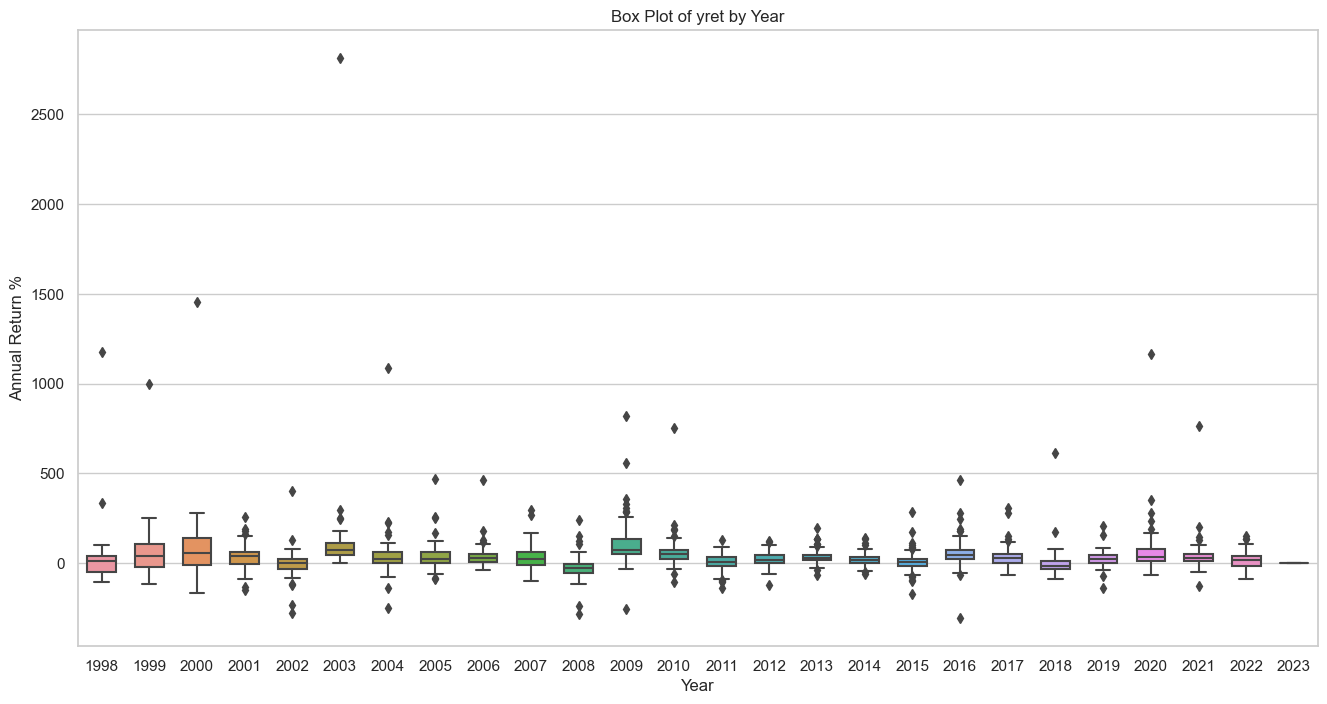

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# visualization yret cross time
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))
sns.boxplot(x='year', y='yret', data=merged_yret, width=0.6)

plt.title('Box Plot of yret by Year')
plt.xlabel('Year')
plt.ylabel('Annual Return %')
plt.show()

In [82]:
portfolio_sale = pd.read_csv('portfolio_sale.csv')

In [83]:
has_missing_values = merged_yret['yret'].isna().any()
has_missing_values

False

In [84]:
sale_df_yret = pd.merge(portfolio_sale, merged_yret, how='inner', left_on=['fyear','gvkey'],right_on=['year','gvkey'])
# unify tag type to facilitsalee by group discuss
sale_df_yret['group_tag'] = sale_df_yret['group_tag'].astype(str)



In [85]:
# Risk free rsalee
rf = pd.read_excel('rfrm.xlsx')
rf['T.Bill Rate'] = rf['T.Bill Rate']*100
rf.rename(columns={'T.Bill Rate': 'rf'}, inplace=True)
sale_df_yret = pd.merge(sale_df_yret, rf, how='inner', left_on=['fyear'],right_on=['Year'])
sale_df_yret = sale_df_yret.drop(columns=['year','Year'])
sale_df_yret['ret_prem'] = sale_df_yret['yret']-sale_df_yret['rf']

/Users/liuqiaochu/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [86]:
sale_df_yret

,fyear,gvkey,sale,p_sale,group_tag,trade,weight_l,weight_s,weight,yret,cap,rf,Implied ERP,ret_prem
0,1998,105365,103.544,677.084138,H,1,0.000200,-0.000000,0.001124,1177.469650,1.330775e+07,4.33,0.0226,1173.139650
1,1998,109084,133.555,997.341919,4,0,0.000000,-0.000000,0.000557,-17.676991,2.163609e+06,4.33,0.0226,-22.006991
2,1998,109185,523.229,0.000000,L,-1,0.000000,-0.000937,-0.002642,34.530883,5.018442e+06,4.33,0.0226,30.200883
3,1998,110533,565.510,161.712437,2,0,0.000000,-0.000000,0.000000,-103.695093,1.856672e+06,4.33,0.0226,-108.025093
4,1998,110566,465.000,3.774194,3,0,0.000000,-0.000000,0.000000,-74.105404,1.639788e+06,4.33,0.0226,-78.435404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,2022,187550,180.364,27.891375,H,1,0.000185,-0.000000,0.001051,66.846619,7.068599e+06,4.42,0.0594,62.426619
1431,2022,187740,675.170,11.623443,L,-1,0.000000,-0.001297,-0.004631,23.805286,4.385416e+07,4.42,0.0594,19.385286
1432,2022,189491,5522.000,0.718900,L,-1,0.000000,-0.010610,-0.017154,18.006903,1.824886e+08,4.42,0.0594,13.586903
1433,2022,196159,46830.300,6.463639,L,-1,0.000000,-0.089982,-0.037283,136.399693,4.441843e+07,4.42,0.0594,131.979693


In [87]:
import pandas as pd
import math

# Assuming rf is defined earlier in your code

# Initialize dictionaries to store results
group_ret = {}
group_std = {}
group_prem = {}

# Loop through each unique tag group
for tag in sale_df_yret['group_tag'].unique():
    tag_data = sale_df_yret[sale_df_yret['group_tag'] == tag].copy()
    exp_ret_year = {}

    # Calculate expected return for each year
    for year in tag_data['fyear'].unique():
        year_data = tag_data[tag_data['fyear'] == year].copy()
        year_data['weight'] = year_data['cap'] / year_data['cap'].sum()
        year_return = (year_data['yret'] * year_data['weight']).sum()
        exp_ret_year[year] = year_return
        
    tag_data['exp_ret_year'] = tag_data['fyear'].map(exp_ret_year)
    tag_data['ret_prem'] = tag_data['exp_ret_year'] - tag_data['rf']
    group = tag_data[['fyear', 'ret_prem', 'exp_ret_year']].drop_duplicates()
    print(group)
    
    # Calculate average yearly return for the group
    exp_ret = group['exp_ret_year'].sum() / len(group['exp_ret_year'])
    std = group['exp_ret_year'].std()/math.sqrt(len(group['exp_ret_year']))
    ret_prem = group['ret_prem'].sum()/ len(group['exp_ret_year'])

    # Store results in dictionaries
    group_ret[tag] = exp_ret
    group_std[tag] = std
    group_prem[tag] = ret_prem
    
    
# Create DataFrames from dictionaries
group_ret_df = pd.DataFrame.from_dict(group_ret, orient='index', columns=['Expected Annual Return %'])
group_std_df = pd.DataFrame.from_dict(group_std, orient='index', columns=['Std %'])
group_prem_df = pd.DataFrame.from_dict(group_prem, orient='index', columns=['Er-Rf %'])

# Merge DataFrames
group_feature = group_ret_df.merge(group_std_df, left_index=True, right_index=True)
group_feature = group_feature.merge(group_prem_df, left_index=True, right_index=True).round(2)

     fyear    ret_prem  exp_ret_year
0     1998  305.505719    309.835719
19    1999   43.229108     48.599108
35    2000   94.711074    100.441074
68    2001   -4.021591     -2.221591
108   2002   17.013864     18.213864
152   2003   92.202634     93.202634
185   2004    6.828292      9.008292
233   2005   30.487515     34.797515
305   2006   39.530775     44.410775
357   2007   34.196566     37.506566
422   2008  -34.150815    -32.560815
507   2009   67.458581     67.598581
569   2010   45.013520     45.143520
631   2011    7.432226      7.462226
710   2014   13.584638     13.637638
792   2015    3.340010      3.550010
871   2016   29.356820     29.866820
945   2012   10.489328     10.539328
1024  2013   26.155143     26.225143
1104  2017   25.065509     26.455509
1161  2018    8.633270     11.003270
1221  2019   30.078857     31.628857
1275  2020   44.863772     44.953772
1331  2021   44.836777     44.896777
1386  2022   -2.407570      2.012430
     fyear    ret_prem  exp_ret_year
1

In [95]:
# calculate t-statistics and Sharpe Ratio
index_order = ['L', '2', '3', '4', 'H']
group_feature = group_feature.reindex(index_order)
group_feature['t-stats'] = (group_feature['Expected Annual Return %'] / group_feature['Std %']).round(2)
group_feature['Sharpe Ratio'] = (group_feature['Er-Rf %'] / group_feature['Std %']).round(2)
group_feature.to_excel('feature_sale.xlsx', index=False)

In [96]:
group_feature

,Expected Annual Return %,Std %,Er-Rf %,t-stats,Sharpe Ratio
L,31.62,4.66,29.75,6.79,6.38
2,25.35,5.84,23.48,4.34,4.02
3,58.89,26.80,57.02,2.20,2.13
4,35.03,8.60,33.16,4.07,3.86
H,41.05,12.62,39.18,3.25,3.10


In [92]:
import numpy as np

exp_ret_year_H = {}
# Filter the original DataFrame to include only rows where tag is 'H' or 'L'
H_df = sale_df_yret[sale_df_yret['group_tag'].isin(['H'])].copy()
for year in H_df['fyear'].unique():
    year_H = H_df[H_df['fyear'] == year].copy()
    year_H['weight'] = year_H['cap'] / year_H['cap'].sum()
    year_H_return = (year_H['yret'] * year_H['weight']).sum()
    exp_ret_year_H[year] = year_H_return   

exp_ret_year_H = pd.DataFrame.from_dict(exp_ret_year_H, orient='index', columns=['ret_H']) 
exp_ret_year_H['rf'] = H_df.groupby('fyear')['rf'].first().values

exp_ret_year_L = {}
# Filter the original DataFrame to include only rows where tag is 'H' or 'L'
L_df = sale_df_yret[sale_df_yret['group_tag'].isin(['L'])].copy()
for year in L_df['fyear'].unique():
    year_L = L_df[L_df['fyear'] == year].copy()
    year_L['weight'] = year_L['cap'] / year_L['cap'].sum()
    year_L_return = (year_L['yret'] * year_L['weight']).sum()
    exp_ret_year_L[year] = year_L_return

exp_ret_year_L = pd.DataFrame.from_dict(exp_ret_year_L, orient='index', columns=['ret_L'])     

merged_df = pd.merge(exp_ret_year_H, exp_ret_year_L, left_index=True, right_index=True)

merged_df['H-L'] = merged_df['ret_H']- merged_df['ret_L']
merged_df['H-L_prem'] = merged_df['H-L']- merged_df['rf']

mean = merged_df['H-L'].mean()
std = merged_df['H-L'].std()/math.sqrt(len(merged_df['H-L']))
mean_prem = merged_df['H-L_prem'].mean()

print(merged_df['H-L'].mean())
print(merged_df['ret_H'].mean())
print(merged_df['ret_L'].mean())

9.426287459400367
41.04828089477681
31.62199343537644


In [93]:
import pandas as pd

# Assuming mean, std, and mean_prem are numpy float64 values
mean_dict = {'HML': mean}
std_dict = {'HML': std}
mean_prem_dict = {'HML': mean_prem}

# Create DataFrames from dictionaries
HML_ret_df = pd.DataFrame.from_dict(mean_dict, orient='index', columns=['Expected Annual Return %'])
HML_std_df = pd.DataFrame.from_dict(std_dict, orient='index', columns=['Std %'])
HML_prem_df = pd.DataFrame.from_dict(mean_prem_dict, orient='index', columns=['Er-Rf %'])

# Merge DataFrames
HML_feature = HML_ret_df.merge(HML_std_df, left_index=True, right_index=True)
HML_feature = HML_feature.merge(HML_prem_df, left_index=True, right_index=True).round(2)

# Calculate t-statistics and Sharpe Ratio
HML_feature['t-stats'] = (HML_feature['Expected Annual Return %'] / HML_feature['Std %']).round(2)
HML_feature['Sharpe Ratio'] = (HML_feature['Er-Rf %'] / HML_feature['Std %']).round(2)

In [94]:
HML_feature

,Expected Annual Return %,Std %,Er-Rf %,t-stats,Sharpe Ratio
HML,9.43,13.35,7.56,0.71,0.57
